<a href="https://colab.research.google.com/github/vietsub00/Perceiver_Notebook/blob/main/Perceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons
!pip install einops

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
import numpy as np
from math import pi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from einops import rearrange, repeat

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.100.76.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.76.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Setup Hyperparameters:

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_classes = 10
img_size = 32
data_dim = img_size**2
num_freq_bands = 6          # number of freq bands, with original value (2 * K + 1)
max_freq = 10.0             # maximum frequency, hyperparameter depending on how fine the data is
batch_size = 64
num_epochs = 150     
ffn_dropout_rate = 0.0
attn_dropout_rate = 0.0
latent_dim = 256      # Size of the latent array.
projection_dim = 29   # Embedding size of each element in the data and latent arrays.
num_heads = 6         # Number of Transformer heads.
ffn_units = [
    projection_dim,
    projection_dim,
    ]                 # Size of the Transformer Feedforward network.
num_transformer_blocks = 6
num_iterations = 8    # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]                      # Size of the Feedforward network of the final classifier.

## Load and preprocess the dataset:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_train shape: {x_test.shape}, y_train shape: {y_test.shape}')

x_train = x_train / 255
x_test = x_test / 255

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_train shape: (10000, 32, 32, 3), y_train shape: (10000, 1)


In [ ]:
def fourier_encode(x, max_freq, num_bands = 4):
  x = tf.expand_dims(x, -1)
  orig_x = x

  scales = tf.linspace(1., max_freq / 2, num_bands)
  scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

  x = x * scales * pi
  x = tf.concat([tf.sin(x), tf.cos(x)], axis = -1)
  x = tf.concat((x, orig_x), axis = -1)
  return x

In [ ]:
max_freq = 10.0
num_freq_bands = 6

b, *axis, _ = x_train.shape

axis_pos = list(map(lambda size: tf.linspace(-1.0, 1.0, num = size), axis))
pos = tf.stack(tf.meshgrid(*axis_pos, indexing = "ij"), axis = -1)
enc_pos = fourier_encode(pos, max_freq, num_freq_bands)
enc_pos = rearrange(enc_pos, "... n d -> ... (n d)")
enc_pos = repeat(enc_pos, "... -> b ...", b = b)

x_train = tf.concat((x_train, enc_pos), axis = -1)
x_train = rearrange(x_train, "b ... d -> b (...) d")
print(x_train.shape)

## Helper Functions:

In [ ]:
def feed_forward(hidden_units, activation='relu', use_bias=True, dropout_rate=0.0):
    layers = []

    for units in hidden_units[:-1]:
        layers.append(layers.Dense(units, activation=activation, use_bias=use_bias))

    layers.append(layers.Dense(units=hidden_units[-1], use_bias=use_bias))
    layers.append(layers.Dropout(dropout_rate))

    ffn = tf.keras.Sequential(layers)
    return ffn

### Cross-attention module
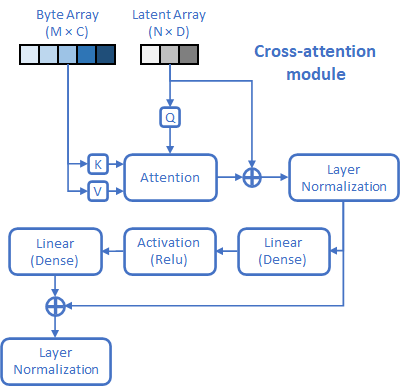&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;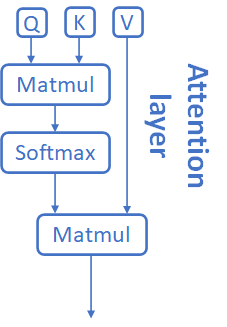

In [ ]:
def cross_attention_module(latent_dim, 
                           data_dim, 
                           projection_dim, 
                           ffn_units, 
                           ffn_dropout_rate = 0,
                           attn_dropout_rate = 0
):
    ''' According to the paper, the latent array has shape (N, D), which 
    corresponding to shape (latent_dim, projection_dim) in this function'''

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim))
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attn_output = layers.Attention(use_scale=True, dropout=attn_dropout_rate)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attn_output = layers.Add()([attn_output, latent_array])
    # Apply layer norm.
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)
    # Apply Feedforward network.
    ffn_output = feed_forward(hidden_units=ffn_units, dropout_rate=ffn_dropout_rate)(attn_output)
    # Skip connection 2.
    ffn_output = layers.Add()([ffn_output, attn_output])
    # Apply layer norm.
    outputs = layers.LayerNormalization(epsilon=1e-6)(attn_output)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Latent Transformer module

In [ ]:
def latent_transformer_module(latent_dim,
                              projection_dim,
                              num_heads,
                              num_transformer_blocks,
                              ffn_units,
                              ffn_dropout_rate = 0,
                              attn_dropout_rate = 0
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, 
                                                key_dim=projection_dim, 
                                                dropout=attn_dropout_rate)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attn_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        x3 = feed_forward(hidden_units=ffn_units, dropout_rate=ffn_dropout_rate)(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=x0)
    return model

## Perceiver class

In [ ]:
class Perceiver(tf.keras.Model):
    def __init__(
        self,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shapes):
        # Create latent array with shape [latent_dim, projection_dim], or (N, D) according to the paper
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal", # we can change the initializer here
            trainable=True,
        )

        # # Create patching module.
        # self.patcher = Patches(self.patch_size)

        # # Create patch encoder.
        # self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            ffn_dropout_rate = self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shapes)

    def call(self, inputs):
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": inputs,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            print('interation:', _)
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits

## Create model:

In [ ]:
def create_model():
  input = layers.Input(input_shape)
  # x = layers.Dropout(0.3)(x)
  #x = layers.Dense(512, activation='relu')(x)
  # x = layers.Flatten()(x)
  #x = layers.Dense(2048, activation='relu')(x)
  # x = layers.Dense(1024, activation='relu')(x)
  # x = layers.Dropout(0.5)(x)
  # x = layers.Dense(512, activation='relu')(x)
  # x = layers.Dropout(0.5)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  output = layers.Dense(num_classes, activation='softmax')(x)

  model = keras.Model(input, output)

  return model

In [ ]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer='Adam', 
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
  model.summary()

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
with strategy.scope():
  history = model.fit(x=data,
                      y=y_train,
                      batch_size=64,
                      epochs=100, 
                      callbacks=[reduce_lr, early_stopping],
                      validation_split=0.2
                      )